# Physics-Informed Bayesian Neural Network

### Physics-based models
Use *physics-based models*, such as transient heat conduction and sintering neck growth models, to predict the temperature and neck growth evolution between each filament. 

Generate **training data** using these *physic-based models*. 

<br>
Model 1 ($F_1$: Heat transfer model):

$X_1 \rightarrow F_1 \rightarrow Y_1$

In the most general case:
<br>
$X_1 = [T_N, s_N, h, w, \rm num_{layer}, \rm num_{filaments}, \theta_1]$
<br>
$Y_1 = T_{int}(t)$

{$T_N, s_N$}: Printer nozzle temperature and speed
<br>
{$h, w$}: layer height and width
<br>
{$\rm num_{layer}, \rm num_{filaments}$}: number of layers, number of filaments per layer
<br>
$\theta_1$: Material properties such as density, specific heat, convective and conduction coefficients
<br>
$T_{int}(t)$: Interface temperature evolution

<br>

Model 2 ($F_2$: Sintering neck growth model):

$X_2 \rightarrow F_2 \rightarrow Y_2$

In the most general case:
<br>
$X_2 = [h, w, \theta_2]$
<br>
$Y_2 = \tau(t), \phi(t)$

$\theta_2$: Model parameters for material viscosity & surface tension
<br>
$\tau(x,y,t)$: bond length between each filament
<br>
$\phi(t)$: porosity of the whole part


### Data-driven model
Use *training data* to train the *(Bayesian) Neural Network* -- Model 3 ($F_3$):.

**Training data** = {$X_3, Y_3$},
<br>
$X_3$: Input,
$Y_3$: Output

*General case*:

$X_3 = [X_1, X_2$]

$Y_3 = [Y_2, Y_{obs}$]

$Y_2$ is modified slightly. The overall mean bond length of the part is used instead of the bond length between each filament.

# Import packages

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
# import numpy as np
# pi, sin, cos, sqrt = np.pi, np.sin, np.cos, np.sqrt
# hth = 0.7e-3
# ao_init = 0.8/2 * 1e-3
# L0 = 35e-3

# eta = 5100 * np.exp(-0.056 * (220 - 240))
# gamma = 0.029 - 3.45e-3 * (220 - 240)

# dt = 0.1
# theta0 = np.sqrt(2 * dt * gamma / (eta * ao_init))
# print(theta0)
# theta = theta0
# # theta = 0.5
# kk = (gamma * hth/ (4 * eta)) * ((2*np.cos(theta)**2)/ ( ((pi*(hth/2)**2) + hth*2*ao_init)*
#             ((-hth/2 * np.sin(theta) + hth/8 - (hth*np.cos(2*theta))/8 )
#              /(hth/2 + ao_init))**2) )
# kk

# Supervised data

In [171]:
def RK_k_eval_np(w0, Gamma, th, eta, H0, L0):

    pi, sin, cos, sqrt = np.pi, np.sin, np.cos, np.sqrt
    w = w0
#     kk_ = (_gamma_ / (3 * ao_init * _eta_ * np.sqrt(pi))) * ((pi - _theta_) * np.cos(_theta_) + np.sin(_theta_)) * (
#             (pi - _theta_ + np.sin(_theta_) * (np.cos(_theta_))) **
#             (1 / 2)) / (((pi - _theta_) ** 2) * ((np.sin(_theta_)) ** 2))
#     kk = -Gamma*H0*(2*L0*pi*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*sin(th)/cos(th)**2 + 2*L0*pi*(-(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - (w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/cos(th) - 4*L0*th*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*sin(th)/cos(th)**2 - 4*L0*th*(-(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - (w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/cos(th) - 4*L0*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/cos(th) + 4*L0*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 + 4*L0*(w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)) + 2*pi*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))**2*sin(th)/cos(th)**3 + pi*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*(-2*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - 2*(w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/cos(th)**2 - (2 - 2*cos(2*th))*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))**4/(2*cos(th)**4) - 2*(2*th - sin(2*th))*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))**4*sin(th)/cos(th)**5 - (2*th - sin(2*th))*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))**3*(-4*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - 4*(w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/(2*cos(th)**4) + 4*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/((pi - 2*th + sin(2*th) - 4*cos(th))**2*cos(th)) + 4*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*sin(th)/((pi - 2*th + sin(2*th) - 4*cos(th))*cos(th)**2) + 4*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*(w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/((pi - 2*th + sin(2*th) - 4*cos(th))*cos(th)) + 4*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - (w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/((pi - 2*th + sin(2*th) - 4*cos(th))*cos(th)))/(8*L0*eta*(-(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - (w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))**2*(H0*pi/4 - H0 + w))
#     kk = -Gamma*(2*L0*pi*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*sin(th)/cos(th)**2 + 2*L0*pi*(-(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - (w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/cos(th) - 4*L0*th*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*sin(th)/cos(th)**2 - 4*L0*th*(-(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - (w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/cos(th) - 4*L0*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/cos(th) + 4*L0*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 + 4*L0*(w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)) + 2*pi*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))**2*sin(th)/cos(th)**3 + pi*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*(-2*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - 2*(w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/cos(th)**2 - (2 - 2*cos(2*th))*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))**4/(2*cos(th)**4) - 2*(2*th - sin(2*th))*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))**4*sin(th)/cos(th)**5 - (2*th - sin(2*th))*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))**3*(-4*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - 4*(w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/(2*cos(th)**4) + 4*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/((pi - 2*th + sin(2*th) - 4*cos(th))**2*cos(th)) + 4*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*sin(th)/((pi - 2*th + sin(2*th) - 4*cos(th))*cos(th)**2) + 4*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*(w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/((pi - 2*th + sin(2*th) - 4*cos(th))*cos(th)) + 4*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - (w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/((pi - 2*th + sin(2*th) - 4*cos(th))*cos(th)))/(4*H0*L0*eta*((w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*sin(th)/(H0*cos(th)**2) + (-(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - (w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/(H0*cos(th)))**2*(H0*pi/4 - H0 + w))
    af = (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th))
    H_f = (w-af)/cos(th)
    kk = -Gamma*H0*(-H_f**4*(2 - 2*cos(2*th))/2 - 4*H_f*L0)/(8*H_f**2*L0*eta*(H0*pi/4 - H0 + w)*sin(th)**2)
#     print("kk: ", kk)
    return kk


def neck_growth_model_2(b2, int_temp, bond_model_param, t_final, dt, hth):
    # Neck growth calculation using the experiment temperature
    # == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == %
    # automatic step size Runge - Kutta - Fehlbergintegration method
    # (Burden and Faires, 1985)
    # To overcome numerical instabilities when theta = 0, the initial BC. is fixed at a time valueslightly different than
    # zero and the corresponding value of theta is determined from Eq. 15
    # They found that the majority of neck growth and sintering in the ABS fibers occurred when the interphase temperature
    # was above 200°C, which meant(based on heat transfer analysis and confirmed by experiments) that the nozzle temperature
    # had a large effect on sintering while environment temperature had little effect. In which delta is time step.
    # For this case, delta is set equal to 2 * dt.  dt is the time step that is used for the interval loop
    # == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == %

    pi, sin, cos, sqrt = np.pi, np.sin, np.cos, np.sqrt
    
    # Filament dimensions
    w0 = 0.8e-3  # Layer Thickness(m)
    H0 = hth * 1e-3  # Layer height(m)
    L0 = 35 * 1e-3  # part length(m)
#     a0 = w0-H0
    w = w0

    # Material properties - ABS
    # Surface tension
    gamma_r = bond_model_param[0]

    # with a temp.dependent of Delta Gamma / Delta T = - 0.00345 N / m / K
    delta_gamma = -bond_model_param[1]

    # print(T.ones(T.ceil(t_final / dt) + 1),type(T.ones(T.ceil(t_final / dt) + 1)))
    # delta_gamma = -b1 * T.ones(T.ceil(t_final / dt) + 1)

    # Temperature dependent viscosity eta_r = 5100 Viscosity at temp 240 celc
    eta_r = bond_model_param[2]

    # b2 = 0.056; # model parameter for temp dependent viscosity
    # b2 = beta # model parameter for temp dependent viscosity

    kelv = 273.15  # Kelvin conversion

    # idx = T.argmin(T.abs(int_temp - (240 + kelv)))
    t_r_c = 240  # reference temperature in C
    t_r = t_r_c + kelv  # in K
    
#     if int_temp[0] > 240 + kelv:
#         gamma = gamma_r
#         eta_ = eta_r
#     else:
#         eta_ = eta_r * np.exp(-b2 * (int_temp[0] - t_r))
#         gamma = gamma_r + delta_gamma * (int_temp[0] - t_r)

#     int_temp = int_temp - 10
    eta_ = eta_r * np.exp(-b2 * (int_temp[0] - t_r))
    gamma = gamma_r + delta_gamma * (int_temp[0] - t_r)
#     theta = np.sqrt(2 * dt * gamma / (eta_ * ao))  # Eq. 15
    theta = (1.5*gamma*H0*dt/(eta_*(w - (w*(pi - 2.0) - 4.0*sqrt(0.0625*H0**2*pi**2 - 0.5*H0**2*pi + H0**2 + 0.25*H0*pi*w - H0*w + 0.25*w**2))/(pi - 4.0))*(H0*pi/4 - H0 + w)))**(1/3)
#     theta = (3*4*gamma*H0*dt*(w - (w*(pi - 2) - (H0**2*pi**2 - 8*H0**2*pi + 16*H0**2 + 4*H0*pi*w - 16*H0*w + 4*w**2)**0.5)/(pi - 4))/(eta_*(H0*pi/4 - H0 + w)))**(1/4)
#     print("theta_0: ",theta, "gamma: ", gamma, "eta:", eta_, "T:", int_temp[0]-kelv, int_temp[1]-kelv, int_temp[2]-kelv)
    pi = (np.pi)  # theano constant pi value
    
    for jjj in range(2, t_final - 1, 2):
        delta_t = 2 * dt  # 2 * time step
        
        # k1 calculation at t_bond(i / 2)
        eta_1 = eta_r * np.exp(-b2 * (int_temp[jjj - 1] - t_r))
        gamma_1 = gamma_r + delta_gamma * (int_temp[jjj - 1] - t_r)
        theta_1 = theta
        k1 = RK_k_eval_np(w0, gamma_1, theta_1, eta_1, H0, L0)

        # k2 calculation
        eta_2 = eta_r * np.exp(-b2 * (int_temp[jjj] - t_r))
        gamma_2 = gamma_r + delta_gamma * (int_temp[jjj] - t_r)
        theta_2 = theta + dt * k1
        k2 = RK_k_eval_np(w0, gamma_2, theta_2, eta_2, H0, L0)

        # k3 calculation
        eta_3 = eta_2
        gamma_3 = gamma_2
        theta_3 = theta + dt * k2
        k3 = RK_k_eval_np(w0, gamma_3, theta_3, eta_3, H0, L0)

        # k4 calculation
        eta_4 = eta_r * np.exp(-b2 * (int_temp[jjj + 1] - t_r))
        gamma_4 = gamma_r + delta_gamma * (int_temp[jjj + 1] - t_r)
        theta_4 = theta + 2 * dt * k3
        k4 = RK_k_eval_np(w0, gamma_4, theta_4, eta_4, H0, L0)

        # theta
        theta += (1 / 6) * delta_t * (k1 + 2 * k2 + 2 * k3 + k4)
#         print("theta_p:",theta, (1 / 6) *delta_t * (k1 + 2 * k2 + 2 * k3 + k4))
    # theta_final = theta[-1] # final value of theta to get the final bond length (corresponding the Ref Temp)

    # y = a * sin(theta)
    # save neck growth for each interface on a given layer
#     bond_length = 2 * ao * np.sin(theta) * 1e3  # BL in mm (2*neckRadius)
#     bond_length = hth * np.sin(theta) * 1e3  # BL in mm (2*neckRadius)
    th = theta
    af = (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th))
    H_f = (w-af)/cos(th)
    
#     bond_length = 1e3 * (w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*sin(th)/cos(th)
    bond_length = 1e3 * H_f*sin(th)
#     print("bl:",bond_length)
    # void area between two filaments
#     void = (hth**2 * np.cos(theta) - (pi*(hth/2)**2 - (hth/2)**2 *(2*theta - np.sin(2*theta)) ))

#     void = -(2*w - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2))**2/(4*pi - 8*th + 4*sin(2*th) - 16*cos(th))
    void = H_f**2*(-pi + 2*th - sin(2*th) + 4*cos(th))/4
    
    # total cross-sec area of a filament
#     total_area = (hth*wt + hth**2 * np.cos(theta))
    
#     total_area = w*(-2*w + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2))/(pi - 2*th + sin(2*th) - 4*cos(th))
    total_area = H_f*(H_f*cos(th) + af)
    return bond_length, void, total_area

# == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == = %
def bond_model_2(beta_, bondmodelparam, totalparts, interface_temp, idx_train, hth):
    # INPUT:
    # bondmodelparam: stores material & model parameters(deterministic)
    # [T_N, v_p, hth, x, y]
    # partinfo: part's information, ...
    # [number of layers, filaments / layer,  total interfaces, and total filaments, T_N v_p hth] in a part

    ctr_ = 0  # counter over number of parts
    dt = 0.15  # time step for the neck growth prediction
    predicted_bl_train = []
    voids, total_areas = [], []
    
    # Predict BLfor each interface of each part
    for partid in range(totalparts):  # loop over each manufactured part ID
#         print("Part:",partid+1)
        int_temp = interface_temp[ctr_]

        # store bond lengths(at Ref_temp) at each interface
        lastnonzeroidx = int_temp.argmin(axis=0)  # return index min. value of temp of each column
        
        # Predict Neck growth at each interface
        for int_id in idx_train[idx_train < int_temp.shape[1]]:  # loop over each interface
            # for int_id in range(numtotalint[ctr_]): # loop over each interface
            
            # final time step
            final_timestep = lastnonzeroidx[int_id]
#             print("Int:",int_id+1)
            # Model Bond Length
            bondlengths, void, tot_area = neck_growth_model_2(beta_, int_temp[0:final_timestep, int_id], bondmodelparam,
                                            final_timestep, dt, hth[partid])

            # Get the bond length at a time when Temperature = Ref_Temp, save BL in mm
            # predicted_bl_train = np.concatenate([bondlengths])
            predicted_bl_train.append(bondlengths)
            voids.append(void)
            total_areas.append(tot_area)


        idx_train = idx_train[idx_train >= int_temp.shape[1]] - int_temp.shape[1]
        # np.delete(idx_train, idx_train<int_temp.shape[1]) # remove the interfaces that are looped over (previous part)

        ctr_ += 1  # increment counter of number of parts

    # predicted_bl_train = (predicted_bl_train - tt.mean(predicted_bl_train)) / tt.std(predicted_bl_train)
    predicted_bl_train = np.array(predicted_bl_train)
    voids = np.array(voids)
    total_areas = np.array(total_areas)
    
    return predicted_bl_train, voids, total_areas

def measurements_and_training_data(num_parts, ratio_, bias):
    # =================================================================================================================== %
    # _______________________________________________       INPUTS     ___________________________________________________
    # =================================================================================================================== %
    wth = 0.8e-3  # width of filaments [m]

    # Reference temperature at which the neck growth is predicted
    ref_temp = 130  # in celcius
    kelv = 273.15  # 0 Celcius in K

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ %

    # =================================================================================================================== %
    # ___________________________________        IMPORT Measured BOND LENGTH DATA     ____________________________________
    # =================================================================================================================== %
    # Directory where measurements are stored
    dir_measurements = "../data/supervised/experiments/"
    dir_temp_data = "../data/supervised/temperature/"

    # IMPORT Measured BOND LENGTH DATA
    start_part_id = 1  # starting ID part
    total_parts = np.arange(start_part_id, num_parts + 1, dtype='int32')

    ctr = 0  # counter of parts
    # num_total_int = 0                              # counter of interfaces
    int_temperature = []  # list stores interface temperature data of all parts' filaments
    measured_bl_row = []  # list stores bond length (BL) data of all parts
    inp = []
    
    # part_info = np.zeros(total_parts.shape[0], dtype='int')
    part_specs = []
    heights = []
    
    hth = 0.7  # same layer height[mm] for all parts
    L = 35 # length of each part in mm
    
    for part_id in total_parts:  # loop over each manufactured part ID

        # Read Process parameters & bond length measurements
        bl_file = dir_measurements + "/Part" + str(part_id) + ".xlsx"

        df = pd.read_excel(bl_file, header=None, sheet_name = 'B')  # read the excel file

        num_layers = df.iloc[2, 0]  # # of layers
        num_interfaces = df.iloc[-2, 1]  # # of interfaces/layer
        num_filaments = num_interfaces + 1  # # of filaments/layer

        # num_layers = int(num_layers)
        # num_interfaces = int(num_interfaces)

        num_interfaces_of_a_part = int(num_layers * num_interfaces)  # num. of interfaces of that part
#         num_filaments_of_a_part = int(num_layers * num_filaments)  # num. of filaments of that part

        # # # of total interface in all parts
        # num_total_int = num_total_int + num_interfaces_of_a_part

        # save printer temperature, speed, height input for each part
        t_n = df.iloc[0, 1]  # Printer nozzle temperature(ºC)
        v_p = df.iloc[0, 3]  # printer speed mm / s
#         hth = df.iloc[0, 5]  # layer height[mm]
        
        t_n = float(t_n)
        v_p = float(v_p)

        # convert data types to float32 for theano
        # hth = hth.astype('float32')

#         print('T_N, v_p, height:', t_n, v_p, hth, "\n")

        raw_measuredbl = df.iloc[2:-1, 3]  # measured bond lengths between each interface
        raw_measuredbl = raw_measuredbl.astype('float32')

        # reshape the measured bond length array & convert to numpy ndarray
        reshaped_measured_bl = raw_measuredbl.values.reshape(num_interfaces, num_layers, order='F').copy()

        # first column is 1st layer and soon(each row is each interface bond length, BL)
        measured_bl = np.fliplr(reshaped_measured_bl)  # flip matrix left to right

        # store measured BL data of all parts in order reshaped in row
        measured_bl_row.append([measured_bl.reshape(num_interfaces_of_a_part).copy()])

        # == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == = %
        # Costa's Analytical Temperature Solution
        # Temperature matrix is saved as csv in "FFE_processDesignVersion_Depo_Seq_SameStartingPointForAllLayers"
        
        # Read Temperature data
        file_name = dir_temp_data + "Part" + str(part_id)

        # extract time array once outside the loop
        filename = file_name + ".csv"
        
        # extract temperature data for 'part_id' part
        data = pd.read_csv(filename, header=None, index_col=None)
        t_c = data.apply(pd.to_numeric, errors='coerce')

        # Kelvin conversion
        kelv = 273.15

        # Convert built Python list of strings to a Numpy float array.
        t_c = np.array(t_c, dtype='float32')

        # separate time from temperature matrix
        time, t_c = t_c[:,0], t_c[:,1:]
        
        # convert Celcius to Kelvin
        temp = t_c + kelv
        
       # == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == = %
        
        # Average two adjacent lines' temperatures to obtain interface temperatures for each interface on that layer
        # initialize matrix for Interface Temperatures
        int_temp = np.zeros((temp.shape[0], num_interfaces_of_a_part), dtype='float32')

        # Interpolate interface temperatures
        kk_int = 0  # count  # of interfaces
        for jj in range(1, num_layers + 1):  # loop over layers
            for ii in range(2, num_filaments + 1):  # loop over filaments on jj - th layer

                kk_fil = (jj - 1) * (num_filaments - 1) + ii + jj - 2  # filament ID
                
                # find the index value when (kk + 1)th filament is started to extruded
                t_idx = np.argmax(temp[:, kk_fil] < t_n + kelv)  # Since argmaxx will stop at the first True

                # find the first index that temp value is lower than Ref_temp
                t_idx_ = np.argmax((temp[:, kk_fil] + temp[:, kk_fil - 1]) / 2 < ref_temp + kelv) + 1

                # average two filament's temp. to obtain interface temp.
                int_temp[0:t_idx_ - t_idx, kk_int] = (temp[t_idx:t_idx_, kk_fil - 1] + temp[t_idx:t_idx_, kk_fil]) / 2
                kk_int += 1

        # store each parts' interface temperature in cell array
        int_temperature.append(int_temp)

        
        
        # Prediction inputs are x & y coordinates of vertical bond length locations
        # x, y coordinate of layer 1 & interface 1(vertical)
        # x = wth;
        ycoord = 0.5 * hth  # 0.5*height of a layer in mm
        iki_y = ycoord * 2

        # store inputs for GP(model disrepancy at each interface)
        for jj in range(1, num_layers + 1):
            for ii in range(1, num_interfaces + 1):
                # use x & y coordinates of vertical bonds as training data for the GP
                # Inp =[ Temperature, speed, height, x, y ]
                inp.append([t_n, v_p, hth, ii * wth, ycoord + (jj - 1) * iki_y])

        
        part_specs.append([t_n, v_p, hth, 1e3*wth, num_layers, num_interfaces, L])
        heights.append(hth)
        
        
        ctr += 1  # increment counter to keep track of total number of parts analyzed

    # Inp: stored inputs for Gaussian process
    # (model disrepancy at each interface):
    #           [T_N, v_p, hth, x, y]
    # Convert built Python lists to a Numpy array.
    inp = np.array(inp, dtype='float32')
    
    # Convert built Python lists to a Numpy array.
    int_temperature = np.array(int_temperature) + bias

    # concatenating different size arrays stored in a list
    measured_bl_row = np.concatenate(measured_bl_row, axis=1)
    measured_bl_row = measured_bl_row.T  # transpose s.t. the number of rows matches Inp

    # stack X and y
    alldata = np.hstack((inp, measured_bl_row))  # stack 2 numpy arrays column-wise

    # -------------------------------------------------------------------------
    #               Random Permutation of Training Data
    # -------------------------------------------------------------------------
    nl = inp.shape[0]  # size of training data

    # randomly select RatioToBeUsed to be training set for GP model
    num_train = round(ratio_ * nl)
#     idx_ = np.random.permutation(nl)
    idx_ = np.arange(nl)  # do not do random permutation

    # Use the first RatioToBeUsed to train the model
    idx_train = idx_[0:num_train]
    
    # train data = [X, Y]
    all_data_train = alldata[idx_train, :]

    # The (1-RatioToBeUsed) will be used to test the model
    idx_test = idx_[(num_train + 1):]
    all_data_test = alldata[idx_test, :]

    x = all_data_train[:, :-1]  # training data, for all but last column
    y = all_data_train[:, -1]  # measurements of the training data, last column
    
    return x, y, ctr, int_temperature, idx_train, heights, part_specs

### Generate training data for the data-driven model (BNN or NN)

In [172]:
# id of the final part that wants to be included in the analysis, 
num_parts_last = 1

# Percent of the whole data is used to train the model
ratio = 1

# bias on the interface temperature predictions
bias = 0.0

# Call the measurements_and_training_data function to get
# x: Training data [printer nozzle temperature (t_n), speed (v_p), layer heigth (hth), x, y (coordinates of bonds)]
# y: bond length measurements at each interface of multiple parts
# numTotalParts: number of total parts analyzed (+1 is the real value because of indexing starts at 0)
# time_frames: time frame data of temperature measurements
# num_interfaces_of_each_part: numpy array stores number of interfaces of each part
# int_temperatures: interface temperature data of each part
# train_idx: randomly selected proportion (ratio) of training data
X, y, numTotalParts, int_temperatures, train_idx, hth, part_specs = \
    measurements_and_training_data(num_parts_last, ratio, bias)

# print("Total number of interfaces (training data size): ", train_idx.shape[0])

# Material parameters for the bond length model
surf_tension = 0.029  # Surface tension
b1_ = 3.45e-3  # Model parameter for temp. dependent surface tension
# viscosity = 550.5  # viscosity at 240 C
viscosity = 5100  # viscosity at 240 C
beta = 0.056
# beta = 0.0206

# viscosity = 150.5  # viscosity at 240 C
# beta = 0.0225

# Input parameters to the neck growth model
ModelParams = [surf_tension, b1_, viscosity]


# Observations: The low fidelity 1-D analytical model
# Predicted_BL: bond length between two filaments of all parts:
Predicted_BL, void_area, total_area = bond_model_2(beta, ModelParams, numTotalParts,
                                  int_temperatures, train_idx, hth)

# convert m^2 to mm^2
void_area = void_area * 1e6 
total_area = total_area * 1e6

inp = np.array(part_specs)
H0, w0 = inp[:,2], inp[:,3]
pi = np.pi
a, b = w0/2, H0/2

# initial porosity
poroi = (H0**2 - pi*b**2)/(H0*(w0-H0)+H0**2)
poroi

array([0.18777661])

In [168]:
# Predicted_BL

# Predict void density
Predict the overall mean bond length and porosity for each part.

Store these values in *bl_void* dictionary.

`mean_tau_ii`: is the mean overall bond length of part *ii* 

`mean_tau`: list stores the mean overall bond lengths of all parts

In [169]:
total_int_minus1, total_int_plus1 = 0, 0

# Dictionary of strings and ints
bl_void = {}

# list of overall mean bond lengths of each part
mean_tau = []
porosities = []
pred_dim_mean_bl = []

# # total cross-sectional area = H x W
# total_area = 4.2 * 12

# loop over number of interfaces of each part
for ii in range(numTotalParts):
    number_interfaces = int_temperatures[ii].shape[1]
    total_int_plus1 += number_interfaces
    
    part_area = total_area[total_int_minus1:total_int_plus1]
    total_part_area = np.sum(total_area[total_int_minus1:total_int_plus1])
    
    part_void = void_area[total_int_minus1:total_int_plus1]
    total_void = np.sum(void_area[total_int_minus1:total_int_plus1])
    
    # dimensionless average bond length (divided by the layer height)
    mean_bl = np.mean(Predicted_BL[total_int_minus1:total_int_plus1])
    dim_mean_bl = mean_bl/part_specs[ii][2]
    
    # porosity of a part
    porosity = total_void/total_part_area
    
    # dimensionless bl measurements
    mean_tau_ii = np.mean(y[total_int_minus1:total_int_plus1])/part_specs[ii][2]
    
    # append each parts' value
    porosities.append(porosity)
    mean_tau.append(mean_tau_ii)
    pred_dim_mean_bl.append(dim_mean_bl)
    
    total_int_minus1 = total_int_plus1
    
    
    
    #     print("part", "temp", "speed", "  height", "layers")
#     print(ii+1,"", [int(x) for x in part_specs[ii][:2]], "\t", 
#           part_specs[ii][2:-1],":\t", total_part_area, total_void, porosity, dim_mean_bl, mean_tau_ii)
    
#     total_void = round(total_void, 4)
#     total_part_area = round(total_part_area, 4)
#     porosity = round(porosity, 4)
#     dim_mean_bl = round(dim_mean_bl, 6)
#     mean_tau_ii = round(mean_tau_ii, 6)
    
    # Adding a new key value pair
    bl_void.update( { (str(ii), str(part_specs[ii][0]), str(part_specs[ii][1]), str(part_specs[ii][2])) : (total_void, total_part_area, porosity, dim_mean_bl, mean_tau_ii)} )

Sort the bond length & porosity (void density) dictionary

In [170]:
pred_dim_mean_bl

[0.2235589834831091]

In [138]:
# sort dict. values (void areas)
print("part", "T_N[C]", "s_N[mm/s]", "h[mm]", "  void_area[mm2]", "total_area[mm2]", " Porosity[%]", " bl_pred", " bl_obs")
{k: v for k, v in sorted(bl_void.items(), key=lambda item: item[0])}

part T_N[C] s_N[mm/s] h[mm]   void_area[mm2] total_area[mm2]  Porosity[%]  bl_pred  bl_obs


{('0', '210.0', '28.0', '0.7'): (7.501153762641929,
  45.70814216808093,
  0.16410979328492944,
  0.2174809297747578,
  0.5690682785851615),
 ('1', '210.0', '28.0', '0.7'): (7.501153762641929,
  45.70814216808093,
  0.16410979328492944,
  0.2174809297747578,
  0.594576895236969),
 ('10', '247.0', '37.0', '0.7'): (6.481625913854047,
  44.688614319293045,
  0.14503976040840874,
  0.2990438057858826,
  0.7490552323205131),
 ('11', '247.0', '37.0', '0.7'): (6.481625913854047,
  44.688614319293045,
  0.14503976040840874,
  0.2990438057858826,
  0.7967903784343175),
 ('12', '255.0', '46.0', '0.7'): (6.194310745397643,
  44.401299150836635,
  0.13950742126609433,
  0.31971924081639713,
  0.6368887424468994),
 ('13', '255.0', '46.0', '0.7'): (6.194310745397643,
  44.401299150836635,
  0.13950742126609433,
  0.31971924081639713,
  0.6302247728620257),
 ('14', '252.0', '21.0', '0.7'): (6.742939120292796,
  44.94992752573181,
  0.1500100109490225,
  0.2795465208479179,
  0.9184735161917551),
 ('1

`mean_tau:` observed BLs
<br>
`pred_dim_mean_bl:` predicted BLs
<br>
`porosities:` porosity of each part

In [139]:
# convert to numpy array
pred_dim_mean_bl = np.array(pred_dim_mean_bl)
porosities = np.array(porosities)
inp = np.array(part_specs)

pred_dim_mean_bl = pred_dim_mean_bl[:, np.newaxis]
porosities = porosities[:, np.newaxis]

X = np.hstack((inp, pred_dim_mean_bl, porosities))  # stack numpy arrays column-wise

In [140]:
Y = np.array(mean_tau)
Y = Y[:, np.newaxis]

In [141]:
# X

In [142]:
# Y

In [143]:
print(X.shape, Y.shape)

(25, 9) (25, 1)


# Include void area measurements

In [144]:
# Read Process parameters & bond length measurements
void_area = "../data/ProcessParametersFinished.xlsx"
df = pd.read_excel(void_area, header=None)  # read the excel file
tot_void = df.iloc[1:, 4]
void_density = tot_void/(12*4.2)
void_density = np.array(void_density)
void_density = void_density[:, np.newaxis]
poroi = poroi[:, np.newaxis]

In [145]:
Y = np.hstack((Y, void_density, poroi))  # stack numpy arrays column-wise
Y

array([[0.5690682785851615, 0.050351665809523785, 0.18777660702723273],
       [0.594576895236969, 0.05232798034126983, 0.18777660702723273],
       [0.6747095925467356, 0.038502739174603166, 0.18777660702723273],
       [0.7374470574515207, 0.03123432053174603, 0.18777660702723273],
       [0.789320639201573, 0.013545543825396815, 0.18777660702723273],
       [0.880823986870902, 0.007495504722222224, 0.18777660702723273],
       [0.8498753820146834, 0.010107506666666665, 0.18777660702723273],
       [0.8303626946040563, 0.012160625960317454, 0.18777660702723273],
       [0.6847628099577768, 0.028705651753968244, 0.18777660702723273],
       [0.7391520908900671, 0.02438435983333333, 0.18777660702723273],
       [0.7490552323205131, 0.023595062896825395, 0.18777660702723273],
       [0.7967903784343175, 0.01626827263492062, 0.18777660702723273],
       [0.6368887424468994, 0.04627013275396824, 0.18777660702723273],
       [0.6302247728620257, 0.044735701619047614, 0.18777660702723273],


# Correlation

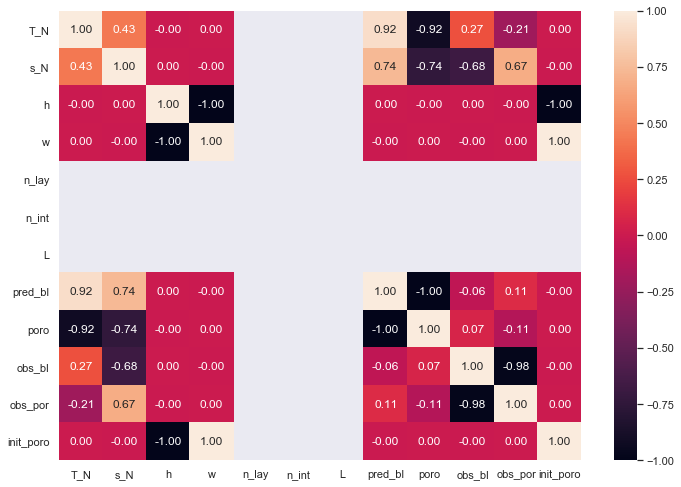

In [146]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

# concatanate input and output
data = np.hstack((X, Y))  # stack numpy arrays column-wise
df1 = pd.DataFrame(data)

# column names
df1.columns = ['T_N','s_N','h',
                     'w','n_lay','n_int','L','pred_bl','poro','obs_bl','obs_por','init_poro']

df1 = df1.astype(float)
# df1.dtypes

# calculate the correlation matrix
corr = df1.corr()

# plot the heatmap
sns.heatmap(corr, annot=True, fmt=".2f")

# try:
#     ax.set_ylim([y.min()-0.05, y.max()+0.05])
# except ValueError:  #raised if `y` is empty.
#     pass

# # fix for mpl bug that cuts off top/bottom of seaborn viz
# b, t = plt.ylim() # discover the values for bottom and top
# b += 0.5 # Add 0.5 to the bottom
# t -= 0.5 # Subtract 0.5 from the top
# plt.ylim(b, t) # update the ylim(bottom, top) values
# plt.show() # ta-da!

In [147]:
# save data
header = "X-Column, Y-Column\n"
header += "Temperature,     speed,     layer height,      layer width,     number of layers,     number of interfaces/layers, length,    pred_wodim_bl,    pred_porosity,   obs_wodim_bl,    obs_poro,     initial porosity"
np.savetxt('../data/labeled_data_BK_constw_v2.dat', data, header=header, fmt='%.14f')

In [148]:
# # load data
# data = np.loadtxt('../data/labeled_data.dat')
# x_labeled = data[:, :-1]
# y_labeled = data[:, -1]
# y_labeled = y_labeled[:, np.newaxis]

In [149]:
# y_labeled.shape

# Unsupervised data

In [2]:
def RK_k_eval_np(w0, Gamma, th, eta, H0, L0):

    pi, sin, cos, sqrt = np.pi, np.sin, np.cos, np.sqrt
    w = w0
    
    af = (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th))
    H_f = (w-af)/cos(th)
    kk = -Gamma*H0*(-H_f**4*(2 - 2*cos(2*th))/2 - 4*H_f*L0)/(8*H_f**2*L0*eta*(H0*pi/4 - H0 + w)*sin(th)**2)
    
    
    
    
#     kk_ = (_gamma_ / (3 * ao_init * _eta_ * np.sqrt(pi))) * ((pi - _theta_) * np.cos(_theta_) + np.sin(_theta_)) * (
#             (pi - _theta_ + np.sin(_theta_) * (np.cos(_theta_))) **
#             (1 / 2)) / (((pi - _theta_) ** 2) * ((np.sin(_theta_)) ** 2))


#     kk = -Gamma*H0*(2*L0*pi*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*sin(th)/cos(th)**2 + 2*L0*pi*(-(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - (w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/cos(th) - 4*L0*th*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*sin(th)/cos(th)**2 - 4*L0*th*(-(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - (w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/cos(th) - 4*L0*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/cos(th) + 4*L0*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 + 4*L0*(w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)) + 2*pi*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))**2*sin(th)/cos(th)**3 + pi*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*(-2*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - 2*(w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/cos(th)**2 - (2 - 2*cos(2*th))*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))**4/(2*cos(th)**4) - 2*(2*th - sin(2*th))*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))**4*sin(th)/cos(th)**5 - (2*th - sin(2*th))*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))**3*(-4*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - 4*(w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/(2*cos(th)**4) + 4*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/((pi - 2*th + sin(2*th) - 4*cos(th))**2*cos(th)) + 4*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*sin(th)/((pi - 2*th + sin(2*th) - 4*cos(th))*cos(th)**2) + 4*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*(w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/((pi - 2*th + sin(2*th) - 4*cos(th))*cos(th)) + 4*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - (w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/((pi - 2*th + sin(2*th) - 4*cos(th))*cos(th)))/(8*L0*eta*(-(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - (w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))**2*(H0*pi/4 - H0 + w))

#     kk = -Gamma*(2*L0*pi*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*sin(th)/cos(th)**2 + 2*L0*pi*(-(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - (w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/cos(th) - 4*L0*th*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*sin(th)/cos(th)**2 - 4*L0*th*(-(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - (w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/cos(th) - 4*L0*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/cos(th) + 4*L0*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 + 4*L0*(w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)) + 2*pi*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))**2*sin(th)/cos(th)**3 + pi*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*(-2*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - 2*(w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/cos(th)**2 - (2 - 2*cos(2*th))*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))**4/(2*cos(th)**4) - 2*(2*th - sin(2*th))*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))**4*sin(th)/cos(th)**5 - (2*th - sin(2*th))*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))**3*(-4*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - 4*(w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/(2*cos(th)**4) + 4*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/((pi - 2*th + sin(2*th) - 4*cos(th))**2*cos(th)) + 4*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*sin(th)/((pi - 2*th + sin(2*th) - 4*cos(th))*cos(th)**2) + 4*(w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*(w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/((pi - 2*th + sin(2*th) - 4*cos(th))*cos(th)) + 4*(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - (w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/((pi - 2*th + sin(2*th) - 4*cos(th))*cos(th)))/(4*H0*L0*eta*((w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*sin(th)/(H0*cos(th)**2) + (-(w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))*(-4*sin(th) - 2*cos(2*th) + 2)/(pi - 2*th + sin(2*th) - 4*cos(th))**2 - (w*(2*sin(th) + 2*cos(2*th) - 2) - (2*H0**2*pi*sin(th) + H0**2*pi*cos(2*th) - H0**2*pi - 8*H0**2*sin(th) - 4*H0**2*cos(2*th) + 4*H0**2 + 8*H0*w*sin(th) + 4*H0*w*cos(2*th) - 4*H0*w)*cos(th)/sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2) + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*sin(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))/(H0*cos(th)))**2*(H0*pi/4 - H0 + w))
    return kk


def neck_growth_model_2(b2, int_temp, bond_model_param, t_final, dt, hth):
    # Neck growth calculation using the experiment temperature
    # == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == %
    # automatic step size Runge - Kutta - Fehlbergintegration method
    # (Burden and Faires, 1985)
    # To overcome numerical instabilities when theta = 0, the initial BC. is fixed at a time valueslightly different than
    # zero and the corresponding value of theta is determined from Eq. 15
    # They found that the majority of neck growth and sintering in the ABS fibers occurred when the interphase temperature
    # was above 200°C, which meant(based on heat transfer analysis and confirmed by experiments) that the nozzle temperature
    # had a large effect on sintering while environment temperature had little effect. In which delta is time step.
    # For this case, delta is set equal to 2 * dt.  dt is the time step that is used for the interval loop
    # == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == %

    pi, sin, cos, sqrt = np.pi, np.sin, np.cos, np.sqrt
    
    # Filament dimensions
    w0 = 0.8e-3  # Layer Thickness(m)
    H0 = hth * 1e-3  # Layer height(m)
    L0 = 35 * 1e-3  # part length(m)
#     a0 = w0-H0
    w = w0

    # Material properties - ABS
    # Surface tension
    gamma_r = bond_model_param[0]

    # with a temp.dependent of Delta Gamma / Delta T = - 0.00345 N / m / K
    delta_gamma = -bond_model_param[1]

    # print(T.ones(T.ceil(t_final / dt) + 1),type(T.ones(T.ceil(t_final / dt) + 1)))
    # delta_gamma = -b1 * T.ones(T.ceil(t_final / dt) + 1)

    # Temperature dependent viscosity eta_r = 5100 Viscosity at temp 240 celc
    eta_r = bond_model_param[2]

    # b2 = 0.056; # model parameter for temp dependent viscosity
    # b2 = beta # model parameter for temp dependent viscosity

    kelv = 273.15  # Kelvin conversion

    # idx = T.argmin(T.abs(int_temp - (240 + kelv)))

    # if int_temp[0] > 240 + kelv:
    #     delta_gamma[0: idx] = -0.0005

    t_r_c = 240  # reference temperature in C
    t_r = t_r_c + kelv  # in K
    
    eta_ = eta_r * np.exp(-b2 * (int_temp[0] - t_r))
    gamma = gamma_r + delta_gamma * (int_temp[0] - t_r)
#     theta = np.sqrt(2 * dt * gamma / (eta_ * ao))  # Eq. 15
    theta = (1.5*gamma*H0*dt/(eta_*(w - (w*(pi - 2.0) - 4.0*sqrt(0.0625*H0**2*pi**2 - 0.5*H0**2*pi + H0**2 + 0.25*H0*pi*w - H0*w + 0.25*w**2))/(pi - 4.0))*(H0*pi/4 - H0 + w)))**(1/3)
#     theta = (3*4*gamma*H0*dt*(w - (w*(pi - 2) - (H0**2*pi**2 - 8*H0**2*pi + 16*H0**2 + 4*H0*pi*w - 16*H0*w + 4*w**2)**0.5)/(pi - 4))/(eta_*(H0*pi/4 - H0 + w)))**(1/4)
#     print("theta_0: ",theta, "dt: ", dt)
    pi = (np.pi)  # theano constant pi value
    
    for jjj in range(3, t_final - 1, 2):
        delta_t = 2 * dt  # 2 * time step

        # k1 calculation at t_bond(i / 2)
        eta_1 = eta_r * np.exp(-b2 * (int_temp[jjj - 1] - t_r))
        gamma_1 = gamma_r + delta_gamma * (int_temp[jjj - 1] - t_r)
        theta_1 = theta
        k1 = RK_k_eval_np(w0, gamma_1, theta_1, eta_1, H0, L0)

        # k2 calculation
        eta_2 = eta_r * np.exp(-b2 * (int_temp[jjj] - t_r))
        gamma_2 = gamma_r + delta_gamma * (int_temp[jjj] - t_r)
        theta_2 = theta + dt * k1
        k2 = RK_k_eval_np(w0, gamma_2, theta_2, eta_2, H0, L0)

        # k3 calculation
        eta_3 = eta_2
        gamma_3 = gamma_2
        theta_3 = theta + dt * k2
        k3 = RK_k_eval_np(w0, gamma_3, theta_3, eta_3, H0, L0)

        # k4 calculation
        eta_4 = eta_r * np.exp(-b2 * (int_temp[jjj + 1] - t_r))
        gamma_4 = gamma_r + delta_gamma * (int_temp[jjj + 1] - t_r)
        theta_4 = theta + 2 * dt * k3
        k4 = RK_k_eval_np(w0, gamma_4, theta_4, eta_4, H0, L0)

        # theta
        theta += (1 / 6) * delta_t * (k1 + 2 * k2 + 2 * k3 + k4)
#         print("theta_p:",theta, (1 / 6) *delta_t * (k1 + 2 * k2 + 2 * k3 + k4))
    # theta_final = theta[-1] # final value of theta to get the final bond length (corresponding the Ref Temp)

    # y = a * sin(theta)
    # save neck growth for each interface on a given layer
#     bond_length = 2 * ao * np.sin(theta) * 1e3  # BL in mm (2*neckRadius)
#     bond_length = hth * np.sin(theta) * 1e3  # BL in mm (2*neckRadius)
    
    th = theta
    af = (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th))
    H_f = (w-af)/cos(th)
    
#     bond_length = 1e3 * (w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*sin(th)/cos(th)
    bond_length = 1e3 * H_f*sin(th)
#     print("bl:",bond_length)
    # void area between two filaments
#     void = (hth**2 * np.cos(theta) - (pi*(hth/2)**2 - (hth/2)**2 *(2*theta - np.sin(2*theta)) ))

#     void = -(2*w - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2))**2/(4*pi - 8*th + 4*sin(2*th) - 16*cos(th))
    void = H_f**2*(-pi + 2*th - sin(2*th) + 4*cos(th))/4
    
    # total cross-sec area of a filament
#     total_area = (hth*wt + hth**2 * np.cos(theta))
    
#     total_area = w*(-2*w + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2))/(pi - 2*th + sin(2*th) - 4*cos(th))
    total_area = H_f*(H_f*cos(th) + af)

    
    
    
    
    
    
#     th = theta
#     bond_length = 1e3 * (w - (w*(pi - 2*th + sin(2*th) - 2*cos(th)) - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2)*cos(th))/(pi - 2*th + sin(2*th) - 4*cos(th)))*sin(th)/cos(th)
    
#     # void area between two filaments
# #     void = (hth**2 * np.cos(theta) - (pi*(hth/2)**2 - (hth/2)**2 *(2*theta - np.sin(2*theta)) ))
#     void = -(2*w - sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2))**2/(4*pi - 8*th + 4*sin(2*th) - 16*cos(th))
    
#     # total cross-sec area of a filament
# #     total_area = (hth*wt + hth**2 * np.cos(theta))
#     total_area = w*(-2*w + sqrt(H0**2*pi**2 - 2*H0**2*pi*th + H0**2*pi*sin(2*th) - 4*H0**2*pi*cos(th) - 4*H0**2*pi + 8*H0**2*th - 4*H0**2*sin(2*th) + 16*H0**2*cos(th) + 4*H0*pi*w - 8*H0*th*w + 4*H0*w*sin(2*th) - 16*H0*w*cos(th) + 4*w**2))/(pi - 2*th + sin(2*th) - 4*cos(th))    
    return bond_length, void, total_area

# == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == = %
def bond_model_2(beta_, bondmodelparam, totalparts, interface_temp, idx_train, hth):
    # INPUT:
    # bondmodelparam: stores material & model parameters(deterministic)
    # [T_N, v_p, hth, x, y]
    # partinfo: part's information, ...
    # [number of layers, filaments / layer,  total interfaces, and total filaments, T_N v_p hth] in a part

    ctr_ = 0  # counter over number of parts
    dt = 0.15  # time step for the neck growth prediction
    predicted_bl_train = []
    voids, total_areas = [], []
    
    # Predict BLfor each interface of each part
    for partid in range(totalparts):  # loop over each manufactured part ID

        int_temp = interface_temp[ctr_]

        # store bond lengths(at Ref_temp) at each interface
        lastnonzeroidx = int_temp.argmin(axis=0)  # return index min. value of temp of each column
        
        # Predict Neck growth at each interface
        for int_id in idx_train[idx_train < int_temp.shape[1]]:  # loop over each interface
            # for int_id in range(numtotalint[ctr_]): # loop over each interface

            # final time step
            final_timestep = lastnonzeroidx[int_id]
            
            # Model Bond Length
            bondlengths, void, tot_area = neck_growth_model_2(beta_, int_temp[0:final_timestep, int_id], bondmodelparam,
                                            final_timestep, dt, hth[partid])

            # Get the bond length at a time when Temperature = Ref_Temp, save BL in mm
            # predicted_bl_train = np.concatenate([bondlengths])
            predicted_bl_train.append(bondlengths)
            voids.append(void)
            total_areas.append(tot_area)

        idx_train = idx_train[idx_train >= int_temp.shape[1]] - int_temp.shape[1]
        # np.delete(idx_train, idx_train<int_temp.shape[1]) # remove the interfaces that are looped over (previous part)

        ctr_ += 1  # increment counter of number of parts

    # predicted_bl_train = (predicted_bl_train - tt.mean(predicted_bl_train)) / tt.std(predicted_bl_train)
    predicted_bl_train = np.array(predicted_bl_train)
    voids = np.array(voids)
    total_areas = np.array(total_areas)
    
    return predicted_bl_train, voids, total_areas

def unsupervised_data(num_parts, bias):
    # =================================================================================================================== %
    # _______________________________________________       INPUTS     ___________________________________________________
    # =================================================================================================================== %
    # Reference temperature at which the neck growth is predicted
    ref_temp = 130  # in celcius
    kelv = 273.15  # 0 Celcius in K

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ %

    # =================================================================================================================== %
    # ___________________________________        IMPORT Measured BOND LENGTH DATA     ____________________________________
    # =================================================================================================================== %
    # Directory where measurements are stored
    dir_measurements = "../data/unsupervised/simulation/"
#     dir_temp_data = "../data/unsupervised/temperature/synthetic_data/" # 25 parts
    dir_temp_data = "../data/unsupervised/temperature/" # 1519 parts

    # IMPORT Measured BOND LENGTH DATA
    start_part_id = 1  # starting ID part
    total_parts = np.arange(start_part_id, num_parts + 1, dtype='int32')

    ctr = 0  # counter of parts
    total_num_int = 0 # total number of interfaces
    int_temperature = []  # list stores interface temperature data of all parts' filaments
    part_specs, heights = [], []

    for part_id in total_parts:  # loop over each manufactured part ID

        # Read Process parameters
#         part_file = dir_measurements + "SyntheticData" + ".csv" # for 25 parts
        part_file = dir_measurements + "Parts" + ".csv" # for 1519 parts
        df = pd.read_csv(part_file, header=None, index_col=None)
        df = df.apply(pd.to_numeric, errors='coerce')
        
        # Process parameters
        t_n = df.iloc[part_id, 0]  # Printer nozzle temperature(ºC)
        v_p = df.iloc[part_id, 1]  # printer speed mm / s
        hth = df.iloc[part_id, 2]  # layer height mm
        wth = df.iloc[part_id, 3]  # layer width mm
        num_layers = int(df.iloc[part_id, 4])  # number of layers
        num_interfaces = int(df.iloc[part_id, 5])  # # of interfaces/layer
        num_interfaces_of_a_part = int(num_layers * num_interfaces)  # total num. of interfaces of that part
        num_filaments = num_interfaces + 1  # # of filaments/layer
        L = df.iloc[part_id, 6]  # # of interfaces/layer
        
        t_n = float(t_n)
        v_p = float(v_p)
        hth = float(hth) # in mm
        wth = float(wth) # in mm
        L = float(L) # in mm
        
#         print(part_id,t_n,v_p,hth,wth,num_layers,num_interfaces)

        # == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == = %
        # Costa's Analytical Temperature Solution
        # Temperature matrix is saved as csv in "FFE_processDesignVersion_Depo_Seq_SameStartingPointForAllLayers"
        
        # Read Temperature data
        file_name = dir_temp_data + "Part" + str(part_id)

        # extract time array once outside the loop
        filename = file_name + ".csv"
        
        # extract temperature data for 'part_id' part
        data = pd.read_csv(filename, header=None, index_col=None)
        t_c = data.apply(pd.to_numeric, errors='coerce')

        # Kelvin conversion
        kelv = 273.15

        # Convert built Python list of strings to a Numpy float array.
        t_c = np.array(t_c, dtype='float32')

        # separate time from temperature matrix
        t_c = t_c[:,:]

        # convert Celcius to Kelvin
        temp = t_c + kelv
        
       # == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == = %
        
        # Average two adjacent lines' temperatures to obtain interface temperatures for each interface on that layer
        # initialize matrix for Interface Temperatures
        int_temp = np.zeros((temp.shape[0], num_interfaces_of_a_part), dtype='float32')

        # Interpolate interface temperatures
        kk_int = 0  # count  # of interfaces
        for jj in range(1, num_layers + 1):  # loop over layers
            for ii in range(2, num_filaments + 1):  # loop over filaments on jj - th layer

                kk_fil = (jj - 1) * (num_filaments - 1) + ii + jj - 2  # filament ID
                
                # find the index value when (kk + 1)th filament is started to extruded
                t_idx = np.argmax(temp[:, kk_fil] < t_n + kelv)  # Since argmaxx will stop at the first True

                # find the first index that temp value is lower than Ref_temp
                t_idx_ = np.argmax((temp[:, kk_fil] + temp[:, kk_fil - 1]) / 2 < ref_temp + kelv) + 1

                # average two filament's temp. to obtain interface temp.
                int_temp[0:t_idx_ - t_idx, kk_int] = (temp[t_idx:t_idx_, kk_fil - 1] + temp[t_idx:t_idx_, kk_fil]) / 2
                kk_int += 1

        # store each parts' interface temperature in cell array
        int_temperature.append(int_temp)

        # == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == = %
        
        part_specs.append([t_n, v_p, hth, wth, num_layers, num_interfaces, L])
        heights.append(hth)
        
        ctr += 1  # increment counter to keep track of total number of parts analyzed
        
        total_num_int += num_interfaces_of_a_part
        
    # Convert built Python lists to a Numpy array.
    int_temperature = np.array(int_temperature) + bias
    
    idx_ = np.arange(total_num_int)  # number of interfaces listed
    
    return ctr, int_temperature, idx_, heights, part_specs

In [3]:
# id of the final part that wants to be included in the analysis, 
num_parts_last = 1519

# bias on the interface temperature predictions
bias = 0.0

# Call the measurements_and_training_data function to get
# x: Training data [printer nozzle temperature (t_n), speed (v_p), layer heigth (hth), x, y (coordinates of bonds)]
# y: bond length measurements at each interface of multiple parts
# numTotalParts: number of total parts analyzed (+1 is the real value because of indexing starts at 0)
# time_frames: time frame data of temperature measurements
# num_interfaces_of_each_part: numpy array stores number of interfaces of each part
# int_temperatures: interface temperature data of each part
# train_idx: randomly selected proportion (ratio) of training data
numTotalParts, int_temperatures, train_idx, hth, part_specs = \
    unsupervised_data(num_parts_last, bias)

# print("Total number of interfaces (training data size): ", train_idx.shape[0])

# Material parameters for the bond length model
surf_tension = 0.029  # Surface tension
b1_ = 3.45e-3  # Model parameter for temp. dependent surface tension
# viscosity = 550.5  # viscosity at 240 C
viscosity = 5100  # viscosity at 240 C
beta = 0.056
# beta = 0.0206

# viscosity = 150.5  # viscosity at 240 C
# beta = 0.0225

# Input parameters to the neck growth model
ModelParams = [surf_tension, b1_, viscosity]


# Observations: The low fidelity 1-D analytical model
# Predicted_BL: bond length between two filaments of all parts:
Predicted_BL, void_area, total_area = bond_model_2(beta, ModelParams, numTotalParts,
                                  int_temperatures, train_idx, hth)

# convert m^2 to mm^2
void_area = void_area * 1e6 
total_area = total_area * 1e6 

inp = np.array(part_specs)
H0, w0 = inp[:,2], inp[:,3]
pi = np.pi
a, b = w0/2, H0/2

# initial porosity
poroi = (H0**2 - pi*b**2)/(H0*(w0-H0)+H0**2)

In [4]:
# Predicted_BL

### Overall mean bond length

In [5]:
total_int_minus1, total_int_plus1 = 0, 0

# list of overall mean bond lengths of each part
unsup_porosities = []
unsup_pred_dim_mean_bl = []

# loop over number of interfaces of each part
for ii in range(numTotalParts):
    number_interfaces = int_temperatures[ii].shape[1]
    total_int_plus1 += number_interfaces
    
    part_area = total_area[total_int_minus1:total_int_plus1]
    total_part_area = np.sum(total_area[total_int_minus1:total_int_plus1])
    
    part_void = void_area[total_int_minus1:total_int_plus1]
    total_void = np.sum(void_area[total_int_minus1:total_int_plus1])
    
    # dimensionless average bond length (divided by the layer height)
    mean_bl = np.mean(Predicted_BL[total_int_minus1:total_int_plus1])
    dim_mean_bl = mean_bl/part_specs[ii][2]
    
    # porosity of a part
    porosity = total_void/total_part_area
    
    # append each parts' value
    unsup_porosities.append(porosity)
    unsup_pred_dim_mean_bl.append(dim_mean_bl)
    
    total_int_minus1 = total_int_plus1

In [6]:
# convert to numpy array
unsup_pred_dim_mean_bl = np.array(unsup_pred_dim_mean_bl)
unsup_porosities = np.array(unsup_porosities)
inp_unsup = np.array(part_specs)

unsup_pred_dim_mean_bl = unsup_pred_dim_mean_bl[:, np.newaxis]
unsup_porosities = unsup_porosities[:, np.newaxis]
poroi = poroi[:, np.newaxis]

X_unsup = np.hstack((inp_unsup, unsup_pred_dim_mean_bl, unsup_porosities, poroi))  # stack numpy arrays column-wise

In [7]:
import seaborn as sns
import pandas as pd
%matplotlib inline

sns.set(rc={'figure.figsize':(11.7,8.27)})

# concatanate input and output
data = X_unsup  # stack numpy arrays column-wise
df = pd.DataFrame(data)

# column names
df.columns = ['T_N','s_N','h',
                     'w','n_lay','n_int','L','pred_bl','poro', 'poroi']
df
# # calculate the correlation matrix
# corr = df.corr()

# # plot the heatmap
# sns.heatmap(corr, 
#         xticklabels=corr.columns,
#         yticklabels=corr.columns, annot=True, fmt='.2f')

# # fix for mpl bug that cuts off top/bottom of seaborn viz
# b, t = plt.ylim() # discover the values for bottom and top
# b += 0.5 # Add 0.5 to the bottom
# t -= 0.5 # Subtract 0.5 from the top
# plt.ylim(b, t) # update the ylim(bottom, top) values
# plt.show() # ta-da!

,T_N,s_N,h,w,n_lay,n_int,L,pred_bl,poro,poroi
0,210.0,15.0,0.7,0.8,6.0,14.0,35.0,0.165900,0.173605,0.187777
1,210.0,16.0,0.7,0.8,6.0,14.0,35.0,0.192973,0.168885,0.187777
2,210.0,17.0,0.7,0.8,6.0,14.0,35.0,0.194474,0.168605,0.187777
3,210.0,18.0,0.7,0.8,6.0,14.0,35.0,0.196053,0.168309,0.187777
4,210.0,19.0,0.7,0.8,6.0,14.0,35.0,0.198670,0.167815,0.187777
...,...,...,...,...,...,...,...,...,...,...
1514,243.0,40.0,0.2,0.2,10.0,20.0,40.0,0.129314,0.051612,0.214602
1515,246.0,42.0,0.2,0.2,10.0,20.0,10.0,0.165853,0.050376,0.214602
1516,249.0,43.0,0.2,0.2,10.0,20.0,6.0,0.173144,0.050098,0.214602
1517,256.0,43.0,0.2,0.2,10.0,20.0,4.0,0.039033,0.053337,0.214602


In [8]:
# save data
header = "X-Column, Y-Column\n"
header += "Temperature,             speed,     layer height,     layer width,   # of layers,     # of interface/layers, length,         pred_dim_bl,     pred_porosity,     initial porosity"
np.savetxt('../data/unlabeled_data_BK_constw_v2_1519.dat', data, header=header, fmt='%.14f')

# # load data
# data = np.loadtxt('../data/unlabeled_data.dat')
# x_unlabeled = data[:, :-1]
# y_unlabeled = data[:, -1]
# y_unlabeled = y_unlabeled[:, np.newaxis]